# AI Controller Development

This notebook develops and tests an AI controller for autonomous agent decision-making in the 3D world environment.

## Overview
- Train intelligent agents using reinforcement learning
- Integrate with Three.js world and LLM system
- Test decision-making algorithms
- Visualize agent behavior and performance

In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Utilities
from collections import deque
import random

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)  # type: ignore
random.seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

Using device: cpu


State shape: (10,)
State: [0.5        0.5        0.88       0.56       0.38470768 1.
 1.         1.         0.17204651 1.        ]
Action space size: 8


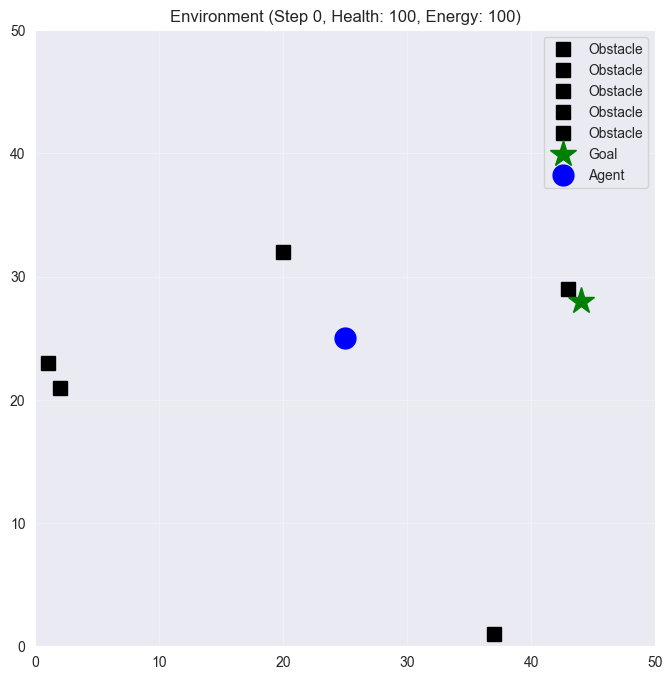

In [13]:
class AgentEnvironment:
    """
    Simulated environment for training AI controller
    """
    def __init__(self, grid_size: int = 50):
        self.grid_size = grid_size
        self.agent_pos = np.array([grid_size // 2, grid_size // 2], dtype=float)
        self.goal_pos = None
        self.obstacles: list[np.ndarray] = []
        self.threats: list[np.ndarray] = []
        self.agent_health = 100
        self.agent_energy = 100
        self.steps = 0
        self.max_steps = 200
        
        # State space: [pos_x, pos_y, goal_x, goal_y, goal_dist, health, energy, 
        #                threat_dist, obstacle_dist, steps_remaining]
        self.state_size = 10
        
        # Action space: 8 discrete actions
        self.action_size = 8
        self.actions = {
            0: 'move_up',
            1: 'move_down',
            2: 'move_left',
            3: 'move_right',
            4: 'move_toward_goal',
            5: 'flee_threat',
            6: 'rest',
            7: 'explore'
        }
        
        self.reset()
    
    def reset(self):
        """Reset environment to initial state"""
        self.agent_pos = np.array([self.grid_size // 2, self.grid_size // 2], dtype=float)
        self.goal_pos = np.array([
            np.random.randint(5, self.grid_size - 5),
            np.random.randint(5, self.grid_size - 5)
        ], dtype=float)
        
        # Random obstacles
        self.obstacles = [
            np.array([np.random.randint(0, self.grid_size), 
                     np.random.randint(0, self.grid_size)])
            for _ in range(5)
        ]
        
        # Random threats
        self.threats = []
        if np.random.random() < 0.3:
            self.threats.append(
                np.array([np.random.randint(0, self.grid_size),
                         np.random.randint(0, self.grid_size)])
            )
        
        self.agent_health = 100
        self.agent_energy = 100
        self.steps = 0
        
        return self._get_state()
    
    def _get_state(self):
        """Get current state vector"""
        # Distance to goal (normalized)
        goal_dist = np.linalg.norm(self.agent_pos - self.goal_pos) / self.grid_size
        
        # Distance to nearest threat
        threat_dist = 1.0  # Max normalized distance
        if self.threats:
            threat_dist = min([np.linalg.norm(self.agent_pos - t) for t in self.threats]) / 50
            threat_dist = min(threat_dist, 1.0)
        
        # Distance to nearest obstacle
        obstacle_dist = 1.0  # Max normalized distance
        if self.obstacles:
            obstacle_dist = min([np.linalg.norm(self.agent_pos - o) for o in self.obstacles]) / 50
            obstacle_dist = min(obstacle_dist, 1.0)
        
        state = np.array([
            self.agent_pos[0] / self.grid_size,
            self.agent_pos[1] / self.grid_size,
            self.goal_pos[0] / self.grid_size,
            self.goal_pos[1] / self.grid_size,
            goal_dist,  # Now included in state
            self.agent_health / 100,
            self.agent_energy / 100,
            threat_dist,
            obstacle_dist,
            (self.max_steps - self.steps) / self.max_steps
        ])
        
        return state
    
    def step(self, action):
        """Execute action and return next state, reward, done"""
        self.steps += 1
        reward = -0.1  # Small penalty per step
        
        # Execute action
        if action == 0:  # move_up
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size - 1)
            self.agent_energy -= 0.5
        elif action == 1:  # move_down
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
            self.agent_energy -= 0.5
        elif action == 2:  # move_left
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
            self.agent_energy -= 0.5
        elif action == 3:  # move_right
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.grid_size - 1)
            self.agent_energy -= 0.5
        elif action == 4:  # move_toward_goal
            direction = self.goal_pos - self.agent_pos
            if np.linalg.norm(direction) > 0:
                direction = direction / np.linalg.norm(direction)
                self.agent_pos += direction * 2
                self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 1)
            self.agent_energy -= 1
            reward += 0.5  # Reward for moving toward goal
        elif action == 5:  # flee_threat
            if self.threats:
                nearest_threat = min(self.threats, key=lambda t: np.linalg.norm(self.agent_pos - t))
                direction = self.agent_pos - nearest_threat
                if np.linalg.norm(direction) > 0:
                    direction = direction / np.linalg.norm(direction)
                    self.agent_pos += direction * 2
                    self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 1)
            self.agent_energy -= 1.5
        elif action == 6:  # rest
            self.agent_energy = min(100, self.agent_energy + 10)
            reward += 0.2
        elif action == 7:  # explore
            self.agent_pos += np.random.randn(2) * 2
            self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size - 1)
            self.agent_energy -= 0.3
        
        # Check threats
        for threat in self.threats:
            if np.linalg.norm(self.agent_pos - threat) < 3:
                self.agent_health -= 10
                reward -= 5
        
        # Check obstacles
        for obstacle in self.obstacles:
            if np.linalg.norm(self.agent_pos - obstacle) < 1:
                reward -= 1
        
        # Check goal
        goal_dist = np.linalg.norm(self.agent_pos - self.goal_pos)
        if goal_dist < 2:
            reward += 100
            done = True
        else:
            reward += (50 - goal_dist) * 0.1  # Reward for getting closer
            done = False
        
        # Check termination conditions
        if self.agent_health <= 0 or self.agent_energy <= 0:
            reward -= 50
            done = True
        elif self.steps >= self.max_steps:
            done = True
        
        next_state = self._get_state()
        
        return next_state, reward, done
    
    def render(self):
        """Visualize the environment"""
        plt.figure(figsize=(8, 8))
        
        # Grid
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        
        # Obstacles
        for obs in self.obstacles:
            plt.plot(obs[0], obs[1], 'ks', markersize=10, label='Obstacle')
        
        # Threats
        for threat in self.threats:
            plt.plot(threat[0], threat[1], 'rs', markersize=15, label='Threat')
        
        # Goal
        plt.plot(self.goal_pos[0], self.goal_pos[1], 'g*', markersize=20, label='Goal')
        
        # Agent
        plt.plot(self.agent_pos[0], self.agent_pos[1], 'bo', markersize=15, label='Agent')
        
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title(f'Environment (Step {self.steps}, Health: {self.agent_health:.0f}, Energy: {self.agent_energy:.0f})')
        plt.show()

# Test the environment
env = AgentEnvironment()
state = env.reset()
print(f"State shape: {state.shape}")
print(f"State: {state}")
print(f"Action space size: {env.action_size}")
env.render()

In [4]:
class DQNetwork(nn.Module):
    """Deep Q-Network for action-value estimation"""
    
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    """Experience replay buffer for stable training"""
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer)


class AIController:
    """AI Controller using DQN"""
    
    def __init__(self, state_size, action_size, config=None):
        self.state_size = state_size
        self.action_size = action_size
        
        # Hyperparameters
        self.config = config or {
            'learning_rate': 0.001,
            'gamma': 0.99,
            'epsilon_start': 1.0,
            'epsilon_end': 0.01,
            'epsilon_decay': 0.995,
            'batch_size': 64,
            'target_update': 10
        }
        
        # Networks
        self.policy_net = DQNetwork(state_size, action_size).to(device)
        self.target_net = DQNetwork(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(
            self.policy_net.parameters(),
            lr=self.config['learning_rate']
        )
        
        # Replay buffer
        self.memory = ReplayBuffer(capacity=10000)
        
        # Training state
        self.epsilon = self.config['epsilon_start']
        self.episode = 0
        self.total_steps = 0
        
        # Metrics - explicitly typed as lists
        self.training_rewards: list[float] = []
        self.training_losses: list[float] = []
        
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()
    
    def train_step(self):
        """Perform one training step"""
        if len(self.memory) < self.config['batch_size']:
            return None
        
        states, actions, rewards, next_states, dones = self.memory.sample(
            self.config['batch_size']
        )
        
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        
        # Current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.config['gamma'] * next_q
        
        # Compute loss
        loss = F.mse_loss(current_q.squeeze(), target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Copy policy network weights to target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(
            self.config['epsilon_end'],
            self.epsilon * self.config['epsilon_decay']
        )

# Initialize controller
controller = AIController(env.state_size, env.action_size)
print(f"Controller initialized")
print(f"Policy network: {controller.policy_net}")
print(f"Starting epsilon: {controller.epsilon}")

Controller initialized
Policy network: DQNetwork(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=8, bias=True)
)
Starting epsilon: 1.0


In [5]:
def train_agent(controller, env, num_episodes=100, verbose=True):
    """
    Train the AI controller in the environment
    
    Args:
        controller: AIController instance
        env: AgentEnvironment instance
        num_episodes: Number of training episodes
        verbose: Print progress
    
    Returns:
        Training history
    """
    episode_rewards = []
    episode_lengths = []
    episode_losses = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss = []
        done = False
        
        while not done:
            # Select action
            action = controller.select_action(state, training=True)
            
            # Execute action
            next_state, reward, done = env.step(action)
            episode_reward += reward
            
            # Store transition
            controller.memory.push(state, action, reward, next_state, done)
            
            # Train
            loss = controller.train_step()
            if loss is not None:
                episode_loss.append(loss)
            
            state = next_state
            controller.total_steps += 1
        
        # Update target network periodically
        if episode % controller.config['target_update'] == 0:
            controller.update_target_network()
        
        # Decay epsilon
        controller.decay_epsilon()
        controller.episode += 1
        
        # Record metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(env.steps)
        avg_loss = np.mean(episode_loss) if episode_loss else 0
        episode_losses.append(avg_loss)
        
        controller.training_rewards.append(episode_reward)
        controller.training_losses.append(avg_loss)
        
        if verbose and (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_length = np.mean(episode_lengths[-10:])
            avg_loss_10 = np.mean(episode_losses[-10:])
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Length: {avg_length:.1f} | "
                  f"Loss: {avg_loss_10:.4f} | "
                  f"ε: {controller.epsilon:.3f}")
    
    return {
        'rewards': episode_rewards,
        'lengths': episode_lengths,
        'losses': episode_losses
    }

print("Training function defined. Ready to train!")

Training function defined. Ready to train!


In [6]:
# Train the controller
print("Starting training...")
print(f"Training for 200 episodes\n")

training_history = train_agent(controller, env, num_episodes=200, verbose=True)

print("\nTraining complete!")
print(f"Final epsilon: {controller.epsilon:.3f}")
print(f"Total steps: {controller.total_steps}")
print(f"Final 10 episode average reward: {np.mean(training_history['rewards'][-10:]):.2f}")

Starting training...
Training for 200 episodes

Episode 10/200 | Avg Reward: 317.38 | Avg Length: 62.4 | Loss: 75.1060 | ε: 0.951
Episode 20/200 | Avg Reward: 218.67 | Avg Length: 32.2 | Loss: 133.3205 | ε: 0.905
Episode 30/200 | Avg Reward: 256.81 | Avg Length: 41.6 | Loss: 125.6797 | ε: 0.860
Episode 40/200 | Avg Reward: 207.42 | Avg Length: 27.2 | Loss: 85.6892 | ε: 0.818
Episode 50/200 | Avg Reward: 210.27 | Avg Length: 28.0 | Loss: 76.9359 | ε: 0.778
Episode 60/200 | Avg Reward: 190.71 | Avg Length: 23.2 | Loss: 63.3397 | ε: 0.740
Episode 70/200 | Avg Reward: 161.28 | Avg Length: 15.3 | Loss: 56.7911 | ε: 0.704
Episode 80/200 | Avg Reward: 171.74 | Avg Length: 18.4 | Loss: 36.2498 | ε: 0.670
Episode 90/200 | Avg Reward: 171.45 | Avg Length: 17.6 | Loss: 23.7087 | ε: 0.637
Episode 100/200 | Avg Reward: 167.17 | Avg Length: 17.7 | Loss: 17.1993 | ε: 0.606
Episode 110/200 | Avg Reward: 157.76 | Avg Length: 14.7 | Loss: 9.4339 | ε: 0.576
Episode 120/200 | Avg Reward: 175.30 | Avg Leng

Testing trained agent...

Test Episode 1: Reward=772.61, Steps=200, Goal Distance=12.37
Test Episode 2: Reward=708.87, Steps=200, Goal Distance=15.56
Test Episode 3: Reward=609.43, Steps=200, Goal Distance=20.52
Test Episode 4: Reward=559.13, Steps=200, Goal Distance=24.32
Test Episode 5: Reward=750.93, Steps=200, Goal Distance=13.45
Test Episode 6: Reward=679.21, Steps=200, Goal Distance=17.03
Test Episode 7: Reward=680.00, Steps=200, Goal Distance=17.00
Test Episode 8: Reward=680.00, Steps=200, Goal Distance=17.00
Test Episode 9: Reward=947.89, Steps=200, Goal Distance=3.61
Test Episode 10: Reward=687.13, Steps=200, Goal Distance=16.64


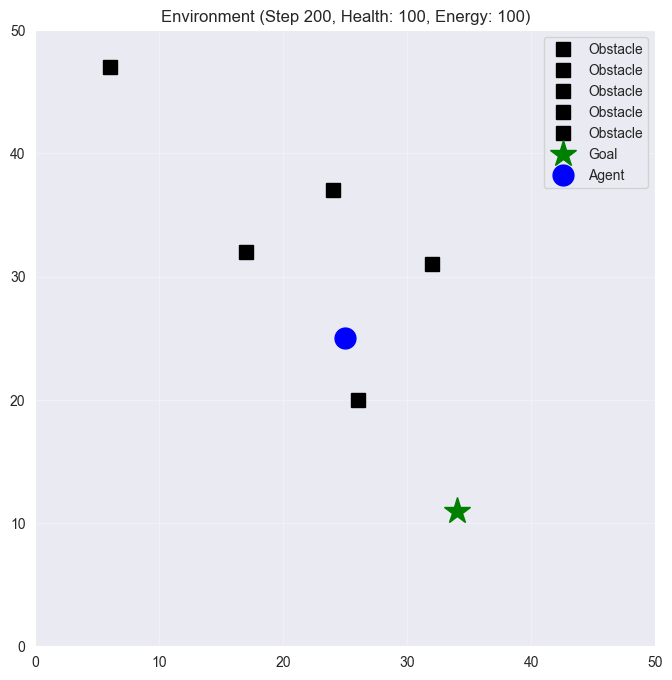


Test Results:
Average Reward: 707.52 ± 99.13
Average Steps: 200.0
Success Rate: 0.0%


In [7]:
def test_agent(controller, env, num_episodes=10, render_last=True):
    """
    Test the trained agent
    
    Args:
        controller: Trained AIController
        env: AgentEnvironment
        num_episodes: Number of test episodes
        render_last: Whether to render the last episode
    
    Returns:
        Test results
    """
    test_rewards = []
    test_lengths = []
    success_count = 0
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            # Select action (no exploration)
            action = controller.select_action(state, training=False)
            
            # Execute action
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state
        
        test_rewards.append(episode_reward)
        test_lengths.append(env.steps)
        
        # Check if goal was reached
        goal_dist = np.linalg.norm(env.agent_pos - env.goal_pos)
        if goal_dist < 2:
            success_count += 1
        
        print(f"Test Episode {episode + 1}: "
              f"Reward={episode_reward:.2f}, "
              f"Steps={env.steps}, "
              f"Goal Distance={goal_dist:.2f}")
        
        # Render last episode
        if render_last and episode == num_episodes - 1:
            env.render()
    
    print(f"\nTest Results:")
    print(f"Average Reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    print(f"Average Steps: {np.mean(test_lengths):.1f}")
    print(f"Success Rate: {success_count / num_episodes * 100:.1f}%")
    
    return {
        'rewards': test_rewards,
        'lengths': test_lengths,
        'success_rate': success_count / num_episodes
    }

# Test the trained agent
print("Testing trained agent...\n")
test_results = test_agent(controller, env, num_episodes=10, render_last=True)

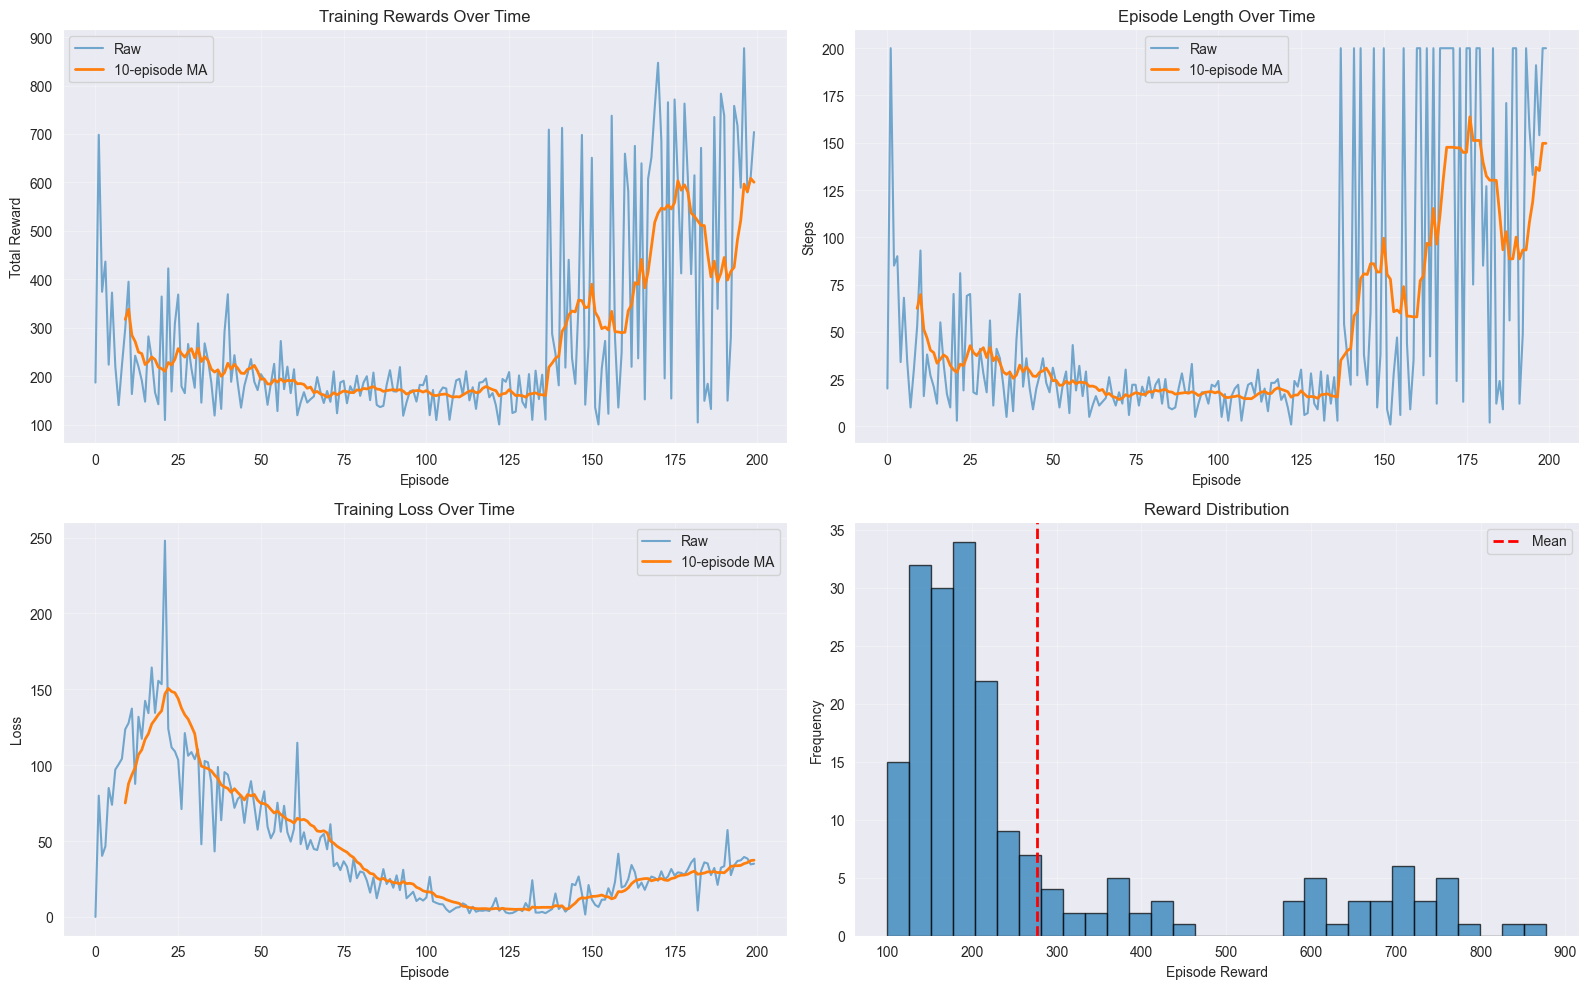


=== Training Summary ===
Total episodes: 200
Total steps: 10502

Rewards:
  Mean: 277.33
  Std: 195.41
  Max: 877.07
  Min: 100.40

Last 20 episodes:
  Avg reward: 506.43
  Avg length: 119.2


In [8]:
# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Episode Rewards
axes[0, 0].plot(training_history['rewards'], alpha=0.6, label='Raw')
# Smooth with moving average
window = 10
if len(training_history['rewards']) >= window:
    rewards_smooth = pd.Series(training_history['rewards']).rolling(window).mean()
    axes[0, 0].plot(rewards_smooth, linewidth=2, label=f'{window}-episode MA')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Training Rewards Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Episode Lengths
axes[0, 1].plot(training_history['lengths'], alpha=0.6, label='Raw')
if len(training_history['lengths']) >= window:
    lengths_smooth = pd.Series(training_history['lengths']).rolling(window).mean()
    axes[0, 1].plot(lengths_smooth, linewidth=2, label=f'{window}-episode MA')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].set_title('Episode Length Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Training Loss
axes[1, 0].plot(controller.training_losses, alpha=0.6, label='Raw')
if len(controller.training_losses) >= window:
    loss_smooth = pd.Series(controller.training_losses).rolling(window).mean()
    axes[1, 0].plot(loss_smooth, linewidth=2, label=f'{window}-episode MA')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Reward Distribution
axes[1, 1].hist(training_history['rewards'], bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(training_history['rewards']), 
                   color='r', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].set_xlabel('Episode Reward')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Reward Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Training Summary ===")
print(f"Total episodes: {len(training_history['rewards'])}")
print(f"Total steps: {controller.total_steps}")
print(f"\nRewards:")
print(f"  Mean: {np.mean(training_history['rewards']):.2f}")
print(f"  Std: {np.std(training_history['rewards']):.2f}")
print(f"  Max: {np.max(training_history['rewards']):.2f}")
print(f"  Min: {np.min(training_history['rewards']):.2f}")
print(f"\nLast 20 episodes:")
print(f"  Avg reward: {np.mean(training_history['rewards'][-20:]):.2f}")
print(f"  Avg length: {np.mean(training_history['lengths'][-20:]):.1f}")

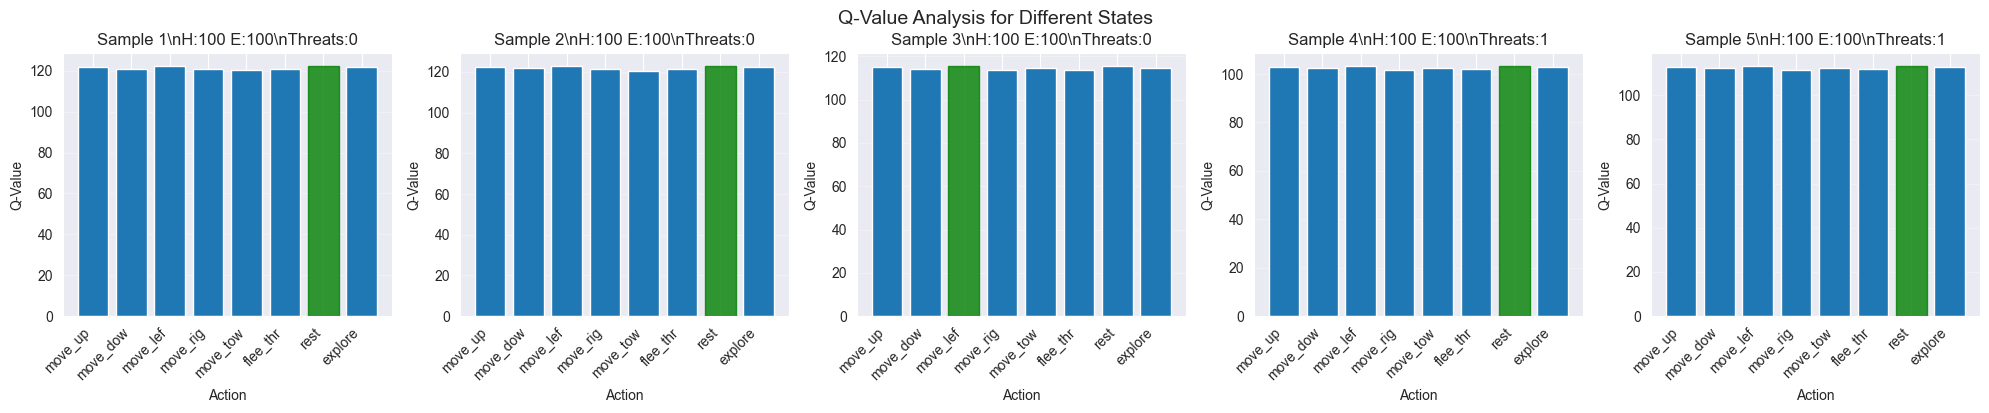


=== Action Distribution During Testing ===


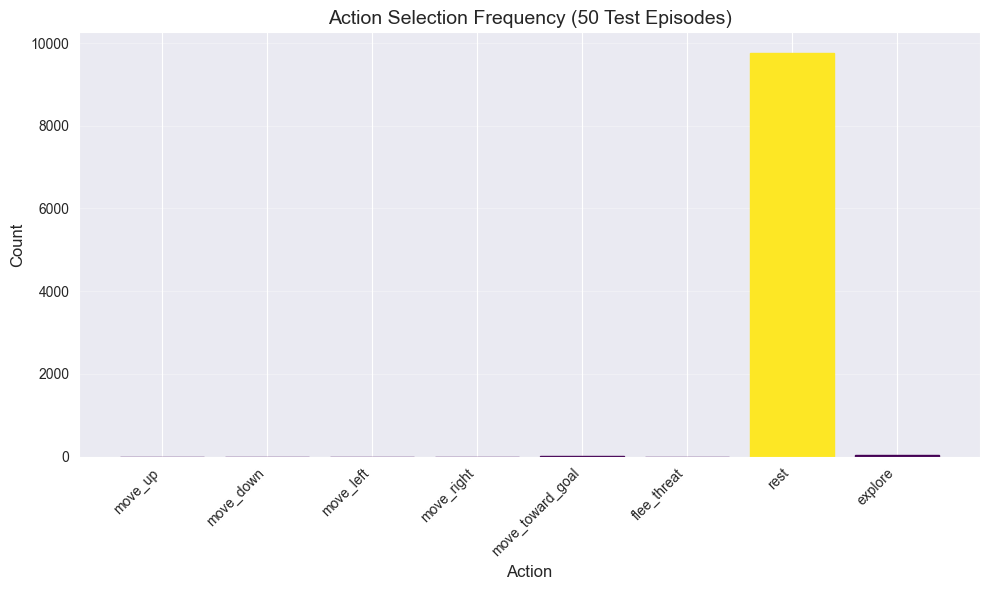


Action frequencies:
move_up             :    0 (  0.0%)
move_down           :    0 (  0.0%)
move_left           :    0 (  0.0%)
move_right          :    0 (  0.0%)
move_toward_goal    :    3 (  0.0%)
flee_threat         :    0 (  0.0%)
rest                : 9771 ( 99.7%)
explore             :   27 (  0.3%)


In [9]:
# Analyze Q-values for different states
def visualize_q_values(controller, env, num_samples=5):
    """Visualize Q-values for sample states"""
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    
    for i in range(num_samples):
        state = env.reset()
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = controller.policy_net(state_tensor).cpu().numpy()[0]
        
        # Plot Q-values
        axes[i].bar(range(env.action_size), q_values)
        axes[i].set_xlabel('Action')
        axes[i].set_ylabel('Q-Value')
        axes[i].set_title(f'Sample {i+1}\\n'
                         f'H:{env.agent_health:.0f} E:{env.agent_energy:.0f}\\n'
                         f'Threats:{len(env.threats)}')
        axes[i].set_xticks(range(env.action_size))
        axes[i].set_xticklabels([env.actions[a][:8] for a in range(env.action_size)], 
                                rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Highlight best action
        best_action = q_values.argmax()
        axes[i].patches[best_action].set_color('green')
        axes[i].patches[best_action].set_alpha(0.8)
    
    plt.tight_layout()
    plt.suptitle('Q-Value Analysis for Different States', y=1.02, fontsize=14)
    plt.show()

visualize_q_values(controller, env, num_samples=5)

# Action distribution analysis
print("\n=== Action Distribution During Testing ===")
action_counts = np.zeros(env.action_size)

for _ in range(50):
    state = env.reset()
    done = False
    while not done:
        action = controller.select_action(state, training=False)
        action_counts[action] += 1
        next_state, reward, done = env.step(action)
        state = next_state

# Plot action distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(range(env.action_size), action_counts)
plt.xlabel('Action', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Action Selection Frequency (50 Test Episodes)', fontsize=14)
plt.xticks(range(env.action_size), 
          [env.actions[a] for a in range(env.action_size)], 
          rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Color bars
colors = plt.cm.viridis(action_counts / action_counts.max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.tight_layout()
plt.show()

print("\nAction frequencies:")
for action_id, count in enumerate(action_counts):
    percentage = count / action_counts.sum() * 100
    print(f"{env.actions[action_id]:20s}: {count:4.0f} ({percentage:5.1f}%)")

In [10]:
# Create directory for models
model_dir = Path('ai_training/controller/models')
model_dir.mkdir(parents=True, exist_ok=True)

# Save PyTorch checkpoint
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_path = model_dir / f'controller_{timestamp}.pth'

checkpoint = {
    'episode': controller.episode,
    'total_steps': controller.total_steps,
    'policy_net_state': controller.policy_net.state_dict(),
    'target_net_state': controller.target_net.state_dict(),
    'optimizer_state': controller.optimizer.state_dict(),
    'epsilon': controller.epsilon,
    'config': controller.config,
    'training_rewards': controller.training_rewards,
    'training_losses': controller.training_losses,
    'state_size': controller.state_size,
    'action_size': controller.action_size
}

torch.save(checkpoint, checkpoint_path)
print(f"✓ Checkpoint saved: {checkpoint_path}")

# Export weights as JSON for JavaScript
weights_export = {}
for name, param in controller.policy_net.state_dict().items():
    weights_export[name] = param.cpu().numpy().tolist()

export_data = {
    'weights': weights_export,
    'config': controller.config,
    'state_size': controller.state_size,
    'action_size': controller.action_size,
    'actions': env.actions,
    'training_stats': {
        'episodes': controller.episode,
        'total_steps': controller.total_steps,
        'final_epsilon': controller.epsilon,
        'avg_reward_last_20': float(np.mean(controller.training_rewards[-20:])),
        'test_success_rate': test_results['success_rate']
    }
}

json_path = model_dir / f'controller_weights_{timestamp}.json'
with open(json_path, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✓ Weights exported: {json_path}")

# Save latest version
latest_path = model_dir / 'controller_latest.pth'
torch.save(checkpoint, latest_path)
print(f"✓ Latest checkpoint: {latest_path}")

latest_json = model_dir / 'controller_latest.json'
with open(latest_json, 'w') as f:
    json.dump(export_data, f, indent=2)
print(f"✓ Latest weights: {latest_json}")

print("\n=== Model Export Complete ===")
print(f"Files saved in: {model_dir.absolute()}")
print(f"\\nTo use in JavaScript:")
print(f"  1. Load weights from: {latest_json}")
print(f"  2. Import AIController from public/AIController.js")
print(f"  3. Initialize with loaded weights")

✓ Checkpoint saved: ai_training\controller\models\controller_20251225_002603.pth
✓ Weights exported: ai_training\controller\models\controller_weights_20251225_002603.json
✓ Latest checkpoint: ai_training\controller\models\controller_latest.pth
✓ Latest weights: ai_training\controller\models\controller_latest.json

=== Model Export Complete ===
Files saved in: c:\Users\Bryan\OneDrive\App\ai_training\controller\models
\nTo use in JavaScript:
  1. Load weights from: ai_training\controller\models\controller_latest.json
  2. Import AIController from public/AIController.js
  3. Initialize with loaded weights


## Next Steps

### Integration with Three.js World
1. Load [public/AIController.js](public/AIController.js) in your game
2. Register agents using `controller.registerAgent()`
3. Call `controller.start()` to begin autonomous behavior

### Training Improvements
- Collect real gameplay data from the 3D world
- Fine-tune with actual agent interactions
- Run [ai_controller_trainer.py](ai_controller_trainer.py) for advanced training

### Further Development
- Add more complex behaviors (cooperation, communication)
- Implement multi-agent scenarios
- Integrate with LLM for natural language reasoning
- Add memory and learning from past experiences

Run this notebook again anytime to retrain and improve the AI controller!

## 9. Save and Export Model

Save the trained controller for deployment in the web application.

In [ ]:
def load_checkpoint(checkpoint_path, state_size, action_size):
    """Load a trained controller from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    controller = AIController(state_size, action_size, checkpoint['config'])
    controller.policy_net.load_state_dict(checkpoint['policy_net_state'])
    controller.target_net.load_state_dict(checkpoint['target_net_state'])
    controller.optimizer.load_state_dict(checkpoint['optimizer_state'])
    controller.epsilon = checkpoint['epsilon']
    controller.episode = checkpoint['episode']
    controller.total_steps = checkpoint['total_steps']
    controller.training_rewards = checkpoint.get('training_rewards', [])
    controller.training_losses = checkpoint.get('training_losses', [])
    
    print(f"✓ Checkpoint loaded: {checkpoint_path}")
    print(f"  Episode: {controller.episode}")
    print(f"  Total steps: {controller.total_steps}")
    print(f"  Epsilon: {controller.epsilon:.3f}")
    
    return controller


def compare_models(models_dict, env, num_test_episodes=20):
    """
    Compare multiple trained models
    
    Args:
        models_dict: Dictionary of {name: controller} pairs
        env: Test environment
        num_test_episodes: Number of episodes to test each model
    
    Returns:
        Comparison results
    """
    results = {}
    
    print(f"Comparing {len(models_dict)} models over {num_test_episodes} episodes each...\n")
    
    for name, controller in models_dict.items():
        print(f"Testing: {name}")
        
        test_rewards = []
        test_lengths = []
        success_count = 0
        
        for ep in range(num_test_episodes):
            state = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                action = controller.select_action(state, training=False)
                next_state, reward, done = env.step(action)
                episode_reward += reward
                state = next_state
            
            test_rewards.append(episode_reward)
            test_lengths.append(env.steps)
            
            goal_dist = np.linalg.norm(env.agent_pos - env.goal_pos)
            if goal_dist < 2:
                success_count += 1
        
        results[name] = {
            'avg_reward': np.mean(test_rewards),
            'std_reward': np.std(test_rewards),
            'avg_length': np.mean(test_lengths),
            'success_rate': success_count / num_test_episodes,
            'rewards': test_rewards
        }
        
        print(f"  Avg Reward: {results[name]['avg_reward']:.2f} ± {results[name]['std_reward']:.2f}")
        print(f"  Success Rate: {results[name]['success_rate']*100:.1f}%\n")
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    names = list(results.keys())
    
    # 1. Average rewards
    avg_rewards = [results[n]['avg_reward'] for n in names]
    std_rewards = [results[n]['std_reward'] for n in names]
    axes[0].bar(range(len(names)), avg_rewards, yerr=std_rewards, capsize=5, alpha=0.7)
    axes[0].set_xticks(range(len(names)))
    axes[0].set_xticklabels(names, rotation=45, ha='right')
    axes[0].set_ylabel('Average Reward')
    axes[0].set_title('Model Performance Comparison', fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Highlight best
    best_idx = np.argmax(avg_rewards)
    axes[0].patches[best_idx].set_color('green')
    axes[0].patches[best_idx].set_alpha(0.9)
    
    # 2. Success rates
    success_rates = [results[n]['success_rate'] * 100 for n in names]
    axes[1].bar(range(len(names)), success_rates, alpha=0.7, color='orange')
    axes[1].set_xticks(range(len(names)))
    axes[1].set_xticklabels(names, rotation=45, ha='right')
    axes[1].set_ylabel('Success Rate (%)')
    axes[1].set_title('Success Rate Comparison', fontweight='bold')
    axes[1].set_ylim(0, 105)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Highlight best
    best_idx = np.argmax(success_rates)
    axes[1].patches[best_idx].set_color('green')
    axes[1].patches[best_idx].set_alpha(0.9)
    
    # 3. Reward distributions
    for name in names:
        axes[2].hist(results[name]['rewards'], alpha=0.5, label=name, bins=15)
    axes[2].set_xlabel('Episode Reward')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Reward Distributions', fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return results


def transfer_learning(source_controller, target_env, num_episodes=50):
    """
    Fine-tune a pre-trained controller on a new environment
    
    Args:
        source_controller: Pre-trained AIController
        target_env: New environment to adapt to
        num_episodes: Number of fine-tuning episodes
    
    Returns:
        Fine-tuned controller
    """
    print("Starting transfer learning...")
    print(f"Source controller trained for {source_controller.episode} episodes")
    
    # Create new controller with same architecture
    target_controller = AIController(
        target_env.state_size,
        target_env.action_size,
        source_controller.config
    )
    
    # Transfer weights (if state/action sizes match)
    if (source_controller.state_size == target_controller.state_size and 
        source_controller.action_size == target_controller.action_size):
        
        target_controller.policy_net.load_state_dict(
            source_controller.policy_net.state_dict()
        )
        target_controller.target_net.load_state_dict(
            source_controller.target_net.state_dict()
        )
        print("✓ Weights transferred successfully")
    else:
        print("⚠ State/action sizes don't match - training from scratch")
    
    # Fine-tune with higher learning rate initially
    original_lr = target_controller.config['learning_rate']
    target_controller.config['learning_rate'] = original_lr * 2
    
    # Reduce epsilon for less exploration (leverage existing knowledge)
    target_controller.epsilon = 0.3
    
    print(f"Fine-tuning for {num_episodes} episodes...")
    history = train_agent(target_controller, target_env, 
                         num_episodes=num_episodes, 
                         verbose=True)
    
    # Restore original learning rate
    target_controller.config['learning_rate'] = original_lr
    
    print("✓ Transfer learning complete!")
    return target_controller, history


# Example usage
print("=== Model Loading and Comparison ===\n")

# Check if we have saved models
model_dir = Path('ai_training/controller/models')
if model_dir.exists():
    checkpoint_files = list(model_dir.glob('controller_*.pth'))
    if checkpoint_files:
        print(f"Found {len(checkpoint_files)} checkpoint files")
        
        # Load latest checkpoint
        latest_checkpoint = model_dir / 'controller_latest.pth'
        if latest_checkpoint.exists():
            loaded_controller = load_checkpoint(latest_checkpoint, env.state_size, env.action_size)
            
            # Compare with newly trained controller
            print("\n--- Model Comparison ---")
            models_to_compare = {
                'Loaded Model': loaded_controller,
                'Current Session': controller
            }
            
            comparison_results = compare_models(models_to_compare, env, num_test_episodes=10)
    else:
        print("No checkpoint files found")
else:
    print(f"Model directory not found: {model_dir}")

print("\n✓ Model comparison and transfer learning capabilities ready!")

## 14. Transfer Learning and Model Comparison

Load pre-trained models, compare different architectures, and enable transfer learning.

In [ ]:
from IPython.display import clear_output
import time

class PerformanceMonitor:
    """Real-time monitoring and benchmarking for AI controller"""
    
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.reset()
    
    def reset(self):
        """Reset all metrics"""
        self.rewards = deque(maxlen=self.window_size)
        self.losses = deque(maxlen=self.window_size)
        self.episode_lengths = deque(maxlen=self.window_size)
        self.success_rate = deque(maxlen=self.window_size)
        self.q_values = deque(maxlen=self.window_size)
        
        self.total_episodes = 0
        self.total_steps = 0
        self.start_time = time.time()
    
    def update(self, reward, loss, episode_length, success, avg_q_value):
        """Update metrics after episode"""
        self.rewards.append(reward)
        self.losses.append(loss)
        self.episode_lengths.append(episode_length)
        self.success_rate.append(1 if success else 0)
        self.q_values.append(avg_q_value)
        
        self.total_episodes += 1
        self.total_steps += episode_length
    
    def get_stats(self):
        """Calculate current statistics"""
        if len(self.rewards) == 0:
            return None
        
        elapsed = time.time() - self.start_time
        
        return {
            'avg_reward': np.mean(self.rewards),
            'std_reward': np.std(self.rewards),
            'avg_loss': np.mean(self.losses),
            'avg_length': np.mean(self.episode_lengths),
            'success_rate': np.mean(self.success_rate) * 100,
            'avg_q_value': np.mean(self.q_values),
            'total_episodes': self.total_episodes,
            'total_steps': self.total_steps,
            'steps_per_sec': self.total_steps / elapsed if elapsed > 0 else 0,
            'elapsed_time': elapsed
        }
    
    def display_live(self, controller, refresh_rate=1):
        """Display live training dashboard"""
        stats = self.get_stats()
        if stats is None:
            return
        
        clear_output(wait=True)
        
        print("=" * 80)
        print(" " * 25 + "🤖 AI CONTROLLER TRAINING DASHBOARD")
        print("=" * 80)
        print()
        
        # Training progress
        print("📊 TRAINING PROGRESS")
        print("-" * 80)
        print(f"Episodes:       {stats['total_episodes']:,}")
        print(f"Total Steps:    {stats['total_steps']:,}")
        print(f"Speed:          {stats['steps_per_sec']:.1f} steps/sec")
        print(f"Elapsed Time:   {stats['elapsed_time']/60:.1f} minutes")
        print()
        
        # Performance metrics
        print("🎯 PERFORMANCE METRICS (Last {0} Episodes)".format(self.window_size))
        print("-" * 80)
        print(f"Avg Reward:     {stats['avg_reward']:>8.2f} ± {stats['std_reward']:.2f}")
        print(f"Avg Loss:       {stats['avg_loss']:>8.4f}")
        print(f"Avg Length:     {stats['avg_length']:>8.1f} steps")
        print(f"Success Rate:   {stats['success_rate']:>8.1f}%")
        print(f"Avg Q-Value:    {stats['avg_q_value']:>8.2f}")
        print()
        
        # Learning state
        print("🧠 LEARNING STATE")
        print("-" * 80)
        print(f"Epsilon:        {controller.epsilon:>8.3f}")
        print(f"Memory Size:    {len(controller.memory):,} / {controller.memory.capacity if hasattr(controller.memory, 'capacity') else 10000:,}")
        print()
        
        # Progress bar for epsilon decay
        epsilon_pct = (controller.config['epsilon_start'] - controller.epsilon) / \
                     (controller.config['epsilon_start'] - controller.config['epsilon_end'])
        epsilon_pct = min(1.0, max(0.0, epsilon_pct))
        bar_len = 40
        filled = int(bar_len * epsilon_pct)
        bar = "█" * filled + "░" * (bar_len - filled)
        print(f"Epsilon Decay:  [{bar}] {epsilon_pct*100:.1f}%")
        print()
        
        # Recent trend
        if len(self.rewards) >= 20:
            recent_trend = np.mean(list(self.rewards)[-10:]) - np.mean(list(self.rewards)[-20:-10])
            trend_symbol = "📈" if recent_trend > 0 else "📉"
            print(f"Recent Trend:   {trend_symbol} {recent_trend:+.2f}")
        
        print("=" * 80)
    
    def plot_live_charts(self):
        """Generate live training charts"""
        if len(self.rewards) < 2:
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 8))
        
        # 1. Rewards
        axes[0, 0].plot(list(self.rewards), linewidth=1.5, color='#2E86AB')
        axes[0, 0].axhline(y=np.mean(self.rewards), color='r', linestyle='--', alpha=0.5)
        axes[0, 0].set_title('Episode Rewards', fontweight='bold')
        axes[0, 0].set_xlabel('Recent Episodes')
        axes[0, 0].set_ylabel('Reward')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Losses
        axes[0, 1].plot(list(self.losses), linewidth=1.5, color='#A23B72')
        axes[0, 1].set_title('Training Loss', fontweight='bold')
        axes[0, 1].set_xlabel('Recent Episodes')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Episode lengths
        axes[0, 2].plot(list(self.episode_lengths), linewidth=1.5, color='#F18F01')
        axes[0, 2].set_title('Episode Length', fontweight='bold')
        axes[0, 2].set_xlabel('Recent Episodes')
        axes[0, 2].set_ylabel('Steps')
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Success rate (rolling)
        axes[1, 0].plot(list(self.success_rate), linewidth=1.5, color='#06A77D')
        axes[1, 0].set_ylim(-0.1, 1.1)
        axes[1, 0].set_title('Success Rate', fontweight='bold')
        axes[1, 0].set_xlabel('Recent Episodes')
        axes[1, 0].set_ylabel('Success (1=Yes, 0=No)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Q-values
        axes[1, 1].plot(list(self.q_values), linewidth=1.5, color='#6A4C93')
        axes[1, 1].set_title('Average Q-Values', fontweight='bold')
        axes[1, 1].set_xlabel('Recent Episodes')
        axes[1, 1].set_ylabel('Q-Value')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Reward histogram
        axes[1, 2].hist(list(self.rewards), bins=20, color='#2E86AB', alpha=0.7, edgecolor='black')
        axes[1, 2].set_title('Reward Distribution', fontweight='bold')
        axes[1, 2].set_xlabel('Reward')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()


def train_with_monitoring(controller, env, num_episodes=100, display_interval=5):
    """Train agent with live performance monitoring"""
    
    monitor = PerformanceMonitor(window_size=50)
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss = []
        episode_q_values = []
        done = False
        
        while not done:
            # Track Q-values
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_vals = controller.policy_net(state_tensor)
                episode_q_values.append(q_vals.max().item())
            
            action = controller.select_action(state, training=True)
            next_state, reward, done = env.step(action)
            episode_reward += reward
            
            controller.memory.push(state, action, reward, next_state, done)
            
            loss = controller.train_step()
            if loss is not None:
                episode_loss.append(loss)
            
            state = next_state
            controller.total_steps += 1
        
        # Update target network
        if episode % controller.config['target_update'] == 0:
            controller.update_target_network()
        
        controller.decay_epsilon()
        controller.episode += 1
        
        # Check success
        goal_dist = np.linalg.norm(env.agent_pos - env.goal_pos)
        success = goal_dist < 2
        
        # Update monitor
        avg_loss = np.mean(episode_loss) if episode_loss else 0
        avg_q = np.mean(episode_q_values) if episode_q_values else 0
        monitor.update(episode_reward, avg_loss, env.steps, success, avg_q)
        
        # Display dashboard
        if (episode + 1) % display_interval == 0:
            monitor.display_live(controller)
            
            if (episode + 1) % (display_interval * 3) == 0:
                monitor.plot_live_charts()
    
    return monitor


# Example: Train with monitoring
print("Starting monitored training session...")
print("Dashboard will update every 5 episodes\n")

monitored_controller = AIController(env.state_size, env.action_size)
monitor = train_with_monitoring(monitored_controller, env, num_episodes=100, display_interval=5)

print("\n✓ Monitored training complete!")
print("Final statistics:")
final_stats = monitor.get_stats()
for key, value in final_stats.items():
    print(f"  {key:20s}: {value}")

## 13. Real-Time Performance Monitoring

Live dashboard for monitoring training progress and agent performance metrics.

In [ ]:
class HyperparameterTuner:
    """Grid search and random search for hyperparameter tuning"""
    
    def __init__(self, env, state_size, action_size):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.results = []
    
    def random_search(self, n_trials=10, episodes_per_trial=50):
        """
        Random search over hyperparameter space
        
        Args:
            n_trials: Number of random configurations to try
            episodes_per_trial: Episodes to train each config
        
        Returns:
            Best configuration and results
        """
        print(f"Starting random search with {n_trials} trials...")
        
        best_config = None
        best_score = float('-inf')
        
        for trial in range(n_trials):
            # Sample random hyperparameters
            config = {
                'learning_rate': np.random.choice([0.0001, 0.0005, 0.001, 0.005]),
                'gamma': np.random.choice([0.95, 0.97, 0.99, 0.995]),
                'epsilon_start': 1.0,
                'epsilon_end': np.random.choice([0.01, 0.05, 0.1]),
                'epsilon_decay': np.random.choice([0.99, 0.995, 0.999]),
                'batch_size': np.random.choice([32, 64, 128]),
                'target_update': np.random.choice([5, 10, 20])
            }
            
            print(f"\n[Trial {trial+1}/{n_trials}]")
            print(f"Config: LR={config['learning_rate']}, γ={config['gamma']}, "
                  f"batch={config['batch_size']}")
            
            # Train with this config
            controller = AIController(self.state_size, self.action_size, config)
            history = train_agent(controller, self.env, 
                                 num_episodes=episodes_per_trial, 
                                 verbose=False)
            
            # Evaluate performance
            avg_reward = np.mean(history['rewards'][-10:])
            
            result = {
                'trial': trial + 1,
                'config': config,
                'avg_reward': avg_reward,
                'rewards': history['rewards']
            }
            self.results.append(result)
            
            print(f"Avg reward (last 10): {avg_reward:.2f}")
            
            # Track best
            if avg_reward > best_score:
                best_score = avg_reward
                best_config = config
                print("★ New best configuration!")
        
        print(f"\n{'='*60}")
        print("HYPERPARAMETER TUNING COMPLETE")
        print(f"{'='*60}")
        print(f"Best score: {best_score:.2f}")
        print(f"Best config:")
        for key, value in best_config.items():
            print(f"  {key:20s}: {value}")
        
        return best_config, self.results
    
    def grid_search(self, param_grid):
        """
        Grid search over specified hyperparameters
        
        Args:
            param_grid: Dictionary with lists of values to try
        
        Returns:
            Best configuration and results
        """
        from itertools import product
        
        # Generate all combinations
        keys = param_grid.keys()
        values = param_grid.values()
        configs = [dict(zip(keys, v)) for v in product(*values)]
        
        print(f"Starting grid search with {len(configs)} configurations...")
        
        best_config = None
        best_score = float('-inf')
        
        for i, config in enumerate(configs):
            print(f"\n[Config {i+1}/{len(configs)}]")
            print(f"Testing: {config}")
            
            # Add default values
            full_config = {
                'learning_rate': 0.001,
                'gamma': 0.99,
                'epsilon_start': 1.0,
                'epsilon_end': 0.01,
                'epsilon_decay': 0.995,
                'batch_size': 64,
                'target_update': 10
            }
            full_config.update(config)
            
            # Train
            controller = AIController(self.state_size, self.action_size, full_config)
            history = train_agent(controller, self.env, 
                                 num_episodes=30, 
                                 verbose=False)
            
            avg_reward = np.mean(history['rewards'][-10:])
            
            result = {
                'config': full_config,
                'avg_reward': avg_reward,
                'rewards': history['rewards']
            }
            self.results.append(result)
            
            print(f"Avg reward: {avg_reward:.2f}")
            
            if avg_reward > best_score:
                best_score = avg_reward
                best_config = full_config
                print("★ New best!")
        
        return best_config, self.results
    
    def plot_results(self):
        """Visualize tuning results"""
        if not self.results:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # 1. Score by trial
        scores = [r['avg_reward'] for r in self.results]
        axes[0, 0].plot(scores, 'o-', linewidth=2, markersize=8)
        axes[0, 0].axhline(y=max(scores), color='r', linestyle='--', 
                          label=f'Best: {max(scores):.2f}')
        axes[0, 0].set_xlabel('Trial')
        axes[0, 0].set_ylabel('Avg Reward (Last 10 Episodes)')
        axes[0, 0].set_title('Performance by Trial')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Learning curves for top 5 configs
        top_5 = sorted(self.results, key=lambda x: x['avg_reward'], reverse=True)[:5]
        for i, result in enumerate(top_5):
            axes[0, 1].plot(result['rewards'], alpha=0.7, 
                          label=f"Trial {result.get('trial', i+1)} ({result['avg_reward']:.1f})")
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Reward')
        axes[0, 1].set_title('Top 5 Configurations - Learning Curves')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Parameter importance (if varied)
        # Analyze learning rate impact
        lrs = {}
        for r in self.results:
            lr = r['config']['learning_rate']
            if lr not in lrs:
                lrs[lr] = []
            lrs[lr].append(r['avg_reward'])
        
        if len(lrs) > 1:
            lr_vals = sorted(lrs.keys())
            lr_means = [np.mean(lrs[lr]) for lr in lr_vals]
            axes[1, 0].bar(range(len(lr_vals)), lr_means, alpha=0.7)
            axes[1, 0].set_xticks(range(len(lr_vals)))
            axes[1, 0].set_xticklabels([f'{lr:.4f}' for lr in lr_vals])
            axes[1, 0].set_xlabel('Learning Rate')
            axes[1, 0].set_ylabel('Avg Reward')
            axes[1, 0].set_title('Learning Rate Impact')
            axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # 4. Score distribution
        axes[1, 1].hist(scores, bins=15, alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(x=np.mean(scores), color='r', linestyle='--', 
                          label=f'Mean: {np.mean(scores):.2f}')
        axes[1, 1].axvline(x=max(scores), color='g', linestyle='--', 
                          label=f'Best: {max(scores):.2f}')
        axes[1, 1].set_xlabel('Avg Reward')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Score Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# Run hyperparameter tuning
print("Initializing Hyperparameter Tuner...")
tuner = HyperparameterTuner(env, env.state_size, env.action_size)

# Run random search (quick example with 5 trials)
best_config, results = tuner.random_search(n_trials=5, episodes_per_trial=30)

# Visualize results
tuner.plot_results()

print("\n✓ Hyperparameter tuning complete!")

## 12. Hyperparameter Optimization

Automatically tune hyperparameters to find the best configuration for training.

In [ ]:
class MultiAgentEnvironment(AgentEnvironment):
    """Environment supporting multiple cooperative agents"""
    
    def __init__(self, grid_size=50, num_agents=2):
        super().__init__(grid_size)
        self.num_agents = num_agents
        self.agent_positions = []
        self.agent_healths = []
        self.agent_energies = []
        
        # Extended state includes other agents' positions
        self.state_size = 10 + (num_agents - 1) * 2  # Base state + relative positions of other agents
        
        self.reset()
    
    def reset(self):
        """Reset with multiple agents"""
        super().reset()
        
        # Initialize agent positions spread out
        self.agent_positions = []
        for i in range(self.num_agents):
            angle = (2 * np.pi * i) / self.num_agents
            radius = self.grid_size // 4
            x = self.grid_size // 2 + radius * np.cos(angle)
            y = self.grid_size // 2 + radius * np.sin(angle)
            self.agent_positions.append(np.array([x, y], dtype=float))
        
        self.agent_healths = [100] * self.num_agents
        self.agent_energies = [100] * self.num_agents
        self.steps = 0
        
        # Single shared goal
        self.goal_pos = np.array([
            np.random.randint(5, self.grid_size - 5),
            np.random.randint(5, self.grid_size - 5)
        ], dtype=float)
        
        return [self._get_state(i) for i in range(self.num_agents)]
    
    def _get_state(self, agent_idx):
        """Get state for specific agent including relative positions of teammates"""
        base_state = np.array([
            self.agent_positions[agent_idx][0] / self.grid_size,
            self.agent_positions[agent_idx][1] / self.grid_size,
            self.goal_pos[0] / self.grid_size,
            self.goal_pos[1] / self.grid_size,
            np.linalg.norm(self.agent_positions[agent_idx] - self.goal_pos) / self.grid_size,
            self.agent_healths[agent_idx] / 100,
            self.agent_energies[agent_idx] / 100,
            min([np.linalg.norm(self.agent_positions[agent_idx] - t) for t in self.threats]) / 50 if self.threats else 1.0,
            min([np.linalg.norm(self.agent_positions[agent_idx] - o) for o in self.obstacles]) / 50 if self.obstacles else 1.0,
            (self.max_steps - self.steps) / self.max_steps
        ])
        
        # Add relative positions of other agents
        for i in range(self.num_agents):
            if i != agent_idx:
                relative_pos = (self.agent_positions[i] - self.agent_positions[agent_idx]) / self.grid_size
                base_state = np.append(base_state, relative_pos)
        
        return base_state
    
    def step(self, actions):
        """Execute actions for all agents simultaneously"""
        self.steps += 1
        rewards = [-0.1] * self.num_agents  # Base penalty
        
        # Execute each agent's action
        for i, action in enumerate(actions):
            if action == 0:  # move_up
                self.agent_positions[i][1] = min(self.agent_positions[i][1] + 1, self.grid_size - 1)
                self.agent_energies[i] -= 0.5
            elif action == 1:  # move_down
                self.agent_positions[i][1] = max(self.agent_positions[i][1] - 1, 0)
                self.agent_energies[i] -= 0.5
            elif action == 2:  # move_left
                self.agent_positions[i][0] = max(self.agent_positions[i][0] - 1, 0)
                self.agent_energies[i] -= 0.5
            elif action == 3:  # move_right
                self.agent_positions[i][0] = min(self.agent_positions[i][0] + 1, self.grid_size - 1)
                self.agent_energies[i] -= 0.5
            elif action == 4:  # move_toward_goal
                direction = self.goal_pos - self.agent_positions[i]
                if np.linalg.norm(direction) > 0:
                    direction = direction / np.linalg.norm(direction)
                    self.agent_positions[i] += direction * 2
                    self.agent_positions[i] = np.clip(self.agent_positions[i], 0, self.grid_size - 1)
                self.agent_energies[i] -= 1
                rewards[i] += 0.5
            elif action == 6:  # rest
                self.agent_energies[i] = min(100, self.agent_energies[i] + 10)
                rewards[i] += 0.2
        
        # Check threats (agents can protect each other)
        for i in range(self.num_agents):
            for threat in self.threats:
                dist_to_threat = np.linalg.norm(self.agent_positions[i] - threat)
                if dist_to_threat < 3:
                    # Check if another agent is nearby to help
                    has_backup = False
                    for j in range(self.num_agents):
                        if i != j and np.linalg.norm(self.agent_positions[i] - self.agent_positions[j]) < 5:
                            has_backup = True
                            break
                    
                    damage = 5 if has_backup else 10
                    self.agent_healths[i] -= damage
                    rewards[i] -= damage / 2
        
        # Cooperative reward: bonus if agents are near each other
        for i in range(self.num_agents):
            for j in range(i + 1, self.num_agents):
                dist = np.linalg.norm(self.agent_positions[i] - self.agent_positions[j])
                if dist < 10:  # Encourage staying together
                    rewards[i] += 0.1
                    rewards[j] += 0.1
        
        # Check goal (team reward if any agent reaches goal)
        done = False
        goal_reached = False
        for i in range(self.num_agents):
            goal_dist = np.linalg.norm(self.agent_positions[i] - self.goal_pos)
            if goal_dist < 2:
                goal_reached = True
                done = True
        
        if goal_reached:
            # All agents get reward for team success
            for i in range(self.num_agents):
                rewards[i] += 100
        
        # Check termination
        if any(h <= 0 or e <= 0 for h, e in zip(self.agent_healths, self.agent_energies)):
            done = True
            for i in range(self.num_agents):
                rewards[i] -= 50
        elif self.steps >= self.max_steps:
            done = True
        
        next_states = [self._get_state(i) for i in range(self.num_agents)]
        
        return next_states, rewards, done
    
    def render(self):
        """Visualize multi-agent environment"""
        plt.figure(figsize=(10, 10))
        
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        
        # Obstacles
        for obs in self.obstacles:
            plt.plot(obs[0], obs[1], 'ks', markersize=10)
        
        # Threats
        for threat in self.threats:
            plt.plot(threat[0], threat[1], 'rs', markersize=15)
        
        # Goal
        plt.plot(self.goal_pos[0], self.goal_pos[1], 'g*', markersize=25, label='Goal')
        
        # Agents (different colors)
        colors = ['blue', 'cyan', 'purple', 'orange']
        for i, pos in enumerate(self.agent_positions):
            plt.plot(pos[0], pos[1], 'o', color=colors[i % len(colors)], 
                    markersize=15, label=f'Agent {i+1}')
            
            # Draw connection lines between agents
            for j in range(i + 1, self.num_agents):
                plt.plot([pos[0], self.agent_positions[j][0]], 
                        [pos[1], self.agent_positions[j][1]], 
                        'k--', alpha=0.2, linewidth=1)
        
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title(f'Multi-Agent Environment (Step {self.steps})')
        plt.show()


# Test multi-agent environment
print("Initializing Multi-Agent Environment...")
multi_env = MultiAgentEnvironment(grid_size=50, num_agents=2)
states = multi_env.reset()
print(f"✓ Multi-agent environment created")
print(f"  - Number of agents: {multi_env.num_agents}")
print(f"  - State size per agent: {multi_env.state_size}")
print(f"  - Cooperative rewards: Enabled")
print(f"\nAgent states:")
for i, state in enumerate(states):
    print(f"  Agent {i+1}: {state.shape}")

multi_env.render()

## 11. Multi-Agent Coordination

Enable multiple agents to learn cooperation and coordination in shared environments.

In [ ]:
class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay Buffer
    Samples experiences based on their TD error for more efficient learning
    """
    
    def __init__(self, capacity=10000, alpha=0.6, beta=0.4):
        self.capacity = capacity
        self.alpha = alpha  # How much prioritization to use (0 = uniform, 1 = full priority)
        self.beta = beta    # Importance sampling correction
        self.beta_increment = 0.001
        
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0
    
    def push(self, state, action, reward, next_state, done):
        """Add experience with maximum priority"""
        max_priority = self.priorities.max() if self.size > 0 else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
        
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        """Sample batch according to priorities"""
        if self.size < batch_size:
            return None
        
        priorities = self.priorities[:self.size]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        
        indices = np.random.choice(self.size, batch_size, p=probabilities, replace=False)
        
        # Calculate importance sampling weights
        weights = (self.size * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()
        
        # Anneal beta
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Extract samples
        samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*samples)
        
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones),
            indices,
            torch.FloatTensor(weights)
        )
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors"""
        for idx, error in zip(indices, td_errors):
            self.priorities[idx] = abs(error) + 1e-6
    
    def __len__(self):
        return self.size


class AdvancedAIController(AIController):
    """Enhanced AI Controller with prioritized replay and double DQN"""
    
    def __init__(self, state_size, action_size, config=None):
        super().__init__(state_size, action_size, config)
        
        # Replace standard buffer with prioritized buffer
        self.memory = PrioritizedReplayBuffer(capacity=10000)
        self.use_double_dqn = True
    
    def train_step(self):
        """Enhanced training step with prioritized replay and double DQN"""
        sample_result = self.memory.sample(self.config['batch_size'])
        
        if sample_result is None:
            return None
        
        states, actions, rewards, next_states, dones, indices, weights = sample_result
        
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        weights = weights.to(device)
        
        # Current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values with Double DQN
        with torch.no_grad():
            if self.use_double_dqn:
                # Use policy network to select actions
                next_actions = self.policy_net(next_states).argmax(1)
                # Use target network to evaluate actions
                next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            else:
                next_q = self.target_net(next_states).max(1)[0]
            
            target_q = rewards + (1 - dones) * self.config['gamma'] * next_q
        
        # Calculate TD errors for priority update
        td_errors = (target_q - current_q.squeeze()).detach().cpu().numpy()
        
        # Weighted loss
        loss = (weights * F.mse_loss(current_q.squeeze(), target_q, reduction='none')).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities
        self.memory.update_priorities(indices, td_errors)
        
        return loss.item()


# Initialize advanced controller
print("Creating Advanced AI Controller with Prioritized Replay...")
advanced_controller = AdvancedAIController(env.state_size, env.action_size)
print("✓ Advanced controller initialized")
print(f"  - Prioritized Experience Replay: Enabled")
print(f"  - Double DQN: Enabled")
print(f"  - Buffer capacity: {len(advanced_controller.memory.buffer)}/{advanced_controller.memory.capacity}")

## 10. Advanced Features: Prioritized Experience Replay

Implement prioritized experience replay to improve learning efficiency by sampling important transitions more frequently.

## 8. Analyze Decision Making

Visualize Q-values and action preferences to understand the agent's decision-making process.

## 7. Visualize Performance

Create comprehensive visualizations of the AI controller's learning progress and decision-making.

## 6. Test the AI Controller

Evaluate the trained controller's performance on test scenarios.

## 5. Train the AI Controller

Train the agent for multiple episodes and observe learning progress.

## 4. Implement Decision Making Logic

Implement the training loop that allows the agent to learn from experience through trial and error.

## 3. Create the AI Controller Class

Define the Deep Q-Network (DQN) architecture and experience replay buffer for the AI controller.

## 2. Define the Environment

Set up the simulation environment where the AI agent will operate. This includes state space (agent observations) and action space (possible actions).

## 1. Import Required Libraries

Import necessary libraries for reinforcement learning, neural networks, and data processing.